In [100]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from ._abstract import AbstractSimulator
from doe_modules.simulation import AbstractSimulator
from doe_modules.design import DOE
from doe_modules.preferences.cmap import sparse


class Sparse(AbstractSimulator):
    def __init__(
        self, 
        random_state: int = 0,
        kwarg_v: dict = dict(mean=1, sigma=.8),
        kwarg_a: dict = dict(mean=2, sigma=.3),
        kwarg_b: dict = dict(mean=1, sigma=.5)
    ):
        super().__init__(n_factor=9, random_state=random_state, cmap=sparse, name=r"Model $\Lambda$")
        seeds = np.random.randint(0, 2**32, 3)
        np.random.seed(seeds[0])
        self.v = {
            i+1: vi for i, vi in enumerate(
                np.random.lognormal(**kwarg_v, size=9)
            )
        }
        np.random.seed(seeds[1])
        self.a = {
            i: a for i, a in zip(
                [1, 2],
                np.random.lognormal(**kwarg_a, size=2)
            )
        }
        np.random.seed(seeds[2])
        self.b = {
            i: b for i, b in zip(
                [45, 46, 47, 57, 67, 78, 79],
                np.random.lognormal(**kwarg_b, size=7)
            )
        }

    def run(
        self, 
        design_array, 
        random_state: int = 0,
        kwarg_err: dict = dict(loc=0, scale=1),
    ):
        super().run(design_array=design_array, random_state=random_state)
        e = np.random.normal(**kwarg_err, size=10)
        f = lambda x: max(0, x)
        c = self.c

        x1 = f(c[1] * (self.v[1] + e[1]))
        x2 = f(c[2] * (self.v[2] + e[2]))
        x3 = f(c[3] * (self.v[3] + e[3]))
        x4 = f(c[4] * (self.v[4] + e[4]))
        x5 = f(c[5] * (self.v[5] + self.b[45] * x4 + e[5]))
        x6 = f(c[6] * (self.v[6] - (self.b[46] * x4) + e[6]))
        x7 = f(
            c[7] * (self.v[7] + self.b[47] * x4 - (self.b[57] * x5) + self.b[67] * x6 + e[7])
        )
        x8 = f(c[8] * (self.v[8] + self.b[78] * x7 + e[8]))
        x9 = f(c[9] * (self.v[9] - (self.b[79] * x7 + e[9])))
        self.c = c
        self.x = {i+1: xi for i, xi in enumerate([x1, x2, x3, x4, x5, x6, x7, x8, x9])}
        self.y = self.a[1] * x1 - (self.a[2] * x2) + e[0]
        return self.y
    

    def plot(
        self,
        ax: plt.Axes
    ):
        ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)

        datdot = pd.DataFrame({
            "name": [
                f"X{i + 1}" if self.x is None else round(self.x[i + 1], 2) for i in range(9)
            ],
            "h": [1, 3, 5, 7, 5, 9, 7, 7, 9],
            "v": [3, 3, 3, 9, 6, 6, 6, 3, 3],
            "c": [
               ".7" if self.x is not None and self.x[i + 1] == 0 else self.cmap[i] for i in range(9)
            ],
            "alpha": [
               .2 if self.x is not None and self.x[i + 1] == 0 else 1 for i in range(9)
            ],
        })

        ax.scatter(data=datdot, x="h", y="v", s=500, color="c", alpha=datdot.alpha)
        ap = lambda n: dict(
            shrink=0, width=1, headwidth=5, 
            headlength=5, connectionstyle="arc3",
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            alpha=datdot.alpha[n - 1]
        )
        ap2 = lambda n: dict(
            arrowstyle="|-|", 
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            linewidth=2, mutation_scale=4,
            alpha=datdot.alpha[n - 1]
        )
        arrconf=dict(ha="center", va="center", zorder=-10)

        ax.annotate("", [1, 1], [1, 3], arrowprops=ap(1), **arrconf)
        ax.annotate("", [3, 1.1], [3, 3], arrowprops=ap2(2), **arrconf)
        ax.annotate("", [5.4, 6.6], [7, 9], arrowprops=ap(4), **arrconf)
        ax.annotate("", [8.6, 6.6], [7, 9], arrowprops=ap2(4), **arrconf)
        ax.annotate("", [7, 6.5], [7, 9], arrowprops=ap(4), **arrconf)
        ax.annotate("", [6.5, 6], [5, 6], arrowprops=ap2(5), **arrconf)
        ax.annotate("", [7.5, 6], [9, 6], arrowprops=ap(6), **arrconf)
        ax.annotate("", [7, 3.5], [7, 6], arrowprops=ap(7), **arrconf)
        ax.annotate("", [8.6, 3.6], [7, 6], arrowprops=ap2(7), **arrconf)

        for i in range(len(datdot)):
            ax.text(
                *datdot.iloc[i, 1:3], datdot.iloc[i, 0], ha="center", va="center",
                size="medium" if self.x is None else 7
            )

        for n, a in self.a.items():
            ax.text(
                datdot.iloc[n - 1, 1], 1.75, "" if datdot.name[n - 1] in [f"X{n}", 0.0] else r"$\times$" + f"{a.round(2)}",
                ha="center", va="center", size=6
            )
        
        for n, b in self.b.items():
            ax.text(
                {45: 6, 46: 8, 47: 7, 57: 6, 67: 8, 78: 7, 79: 8}[n],
                {45: 7.5, 46: 7.5, 47: 7.5, 57: 6, 67: 6, 78: 4.5, 79: 4.5}[n],
                "" if datdot.name[int(str(n)[0]) - 1] in [f"X{int(str(n)[0])}", 0.0] else r"$\times$" + f"{b.round(2)}",
                ha="center", va="center", size=6
            )
        
        if self.c is not None:
            for n, c in self.c.items():
                ax.scatter(
                    *{i + 1: (h, v) for i, h, v in zip(range(9), datdot.h, datdot.v)}[n],
                    marker="x", s=300, color="r"
                ) if c == 0 else None

        ax.text(5, .5, "output value" if self.y is None else round(self.y, 2), ha="center", va="center")

        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])

        ax.axis("off")
        return None


    def simulate(
        self,
        design: DOE = None,
        n_rep: int = 1,
        random_state: int = 0,
        plot: bool = False,
        ax: np.ndarray = None,
        titles: List[str] = None,
        model_kwargs: dict = {},
        **kwargs
    ):
        super().simulate(
            design=design, n_rep=n_rep,
            random_state=random_state,
            plot=plot, ax=ax, 
            titles=titles,
            model_kwargs=model_kwargs,
            **kwargs
        )


    def scatterview(
        self,
        ax: plt.Axes
    ):
        super().scatterview(ax=ax)

In [101]:
from doe_modules.design import CLOO

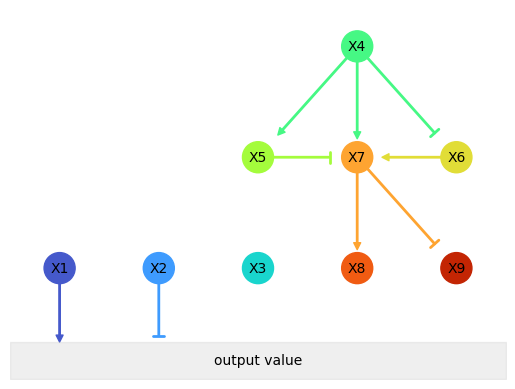

In [102]:
fig, ax = plt.subplots()
Sparse().plot(ax)

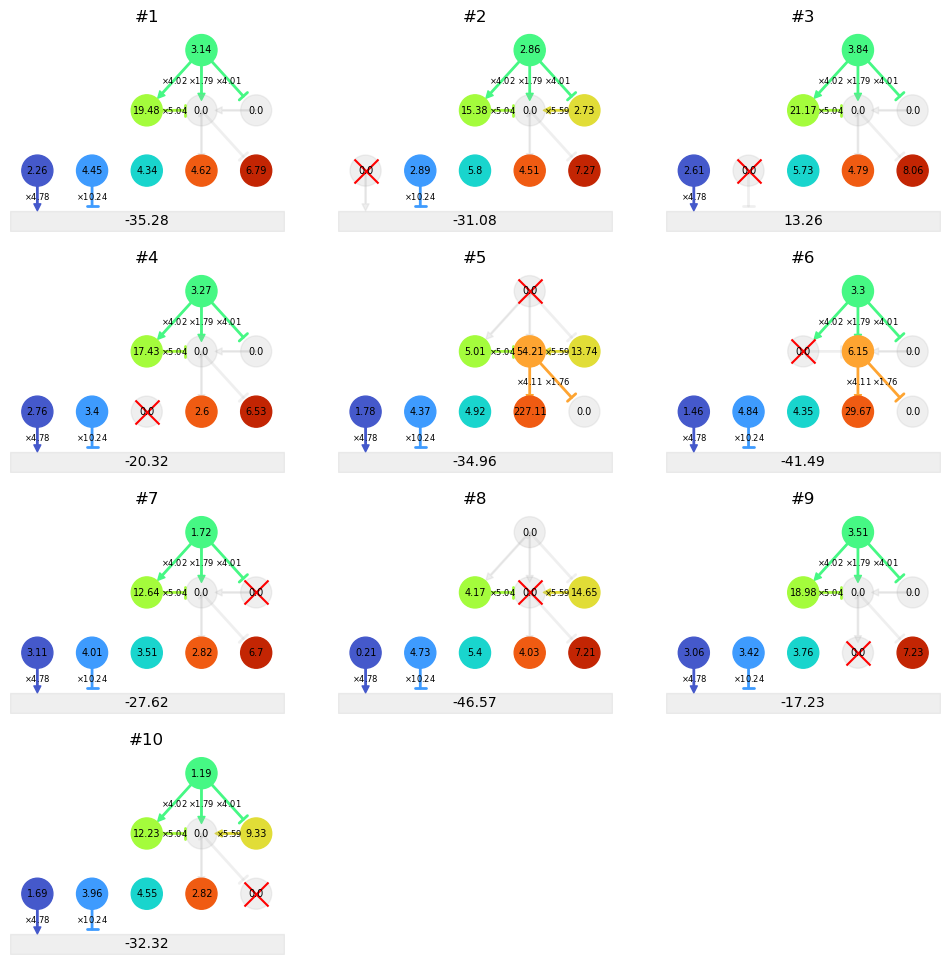

In [103]:
fig, ax = plt.subplots(4, 3, figsize=(12, 12))

model = Sparse()
model.simulate(
    design=CLOO, plot=True, ax=ax
)

In [108]:
x

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4])

In [110]:
y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4])

In [112]:
x

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4])

In [117]:
top

array([0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5,
       6, 7, 8])

In [118]:
top = np.array([
    [0, 0, 0, 0, 0],
    [0, 2, 0, 3, 0],
    [0, 0, 0, 0, 0],
    [0, 4, 0, 5, 0],
    [0, 0, 0, 0, 0]
]).ravel()

In [227]:
from doe_modules.preferences import kwarg_savefig

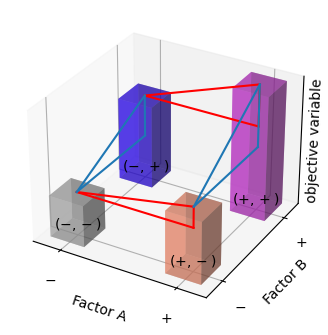

In [236]:
fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

a = 2
b = 3
c = 4
d = 6

width = depth = .3
center = depth / 2

ax.bar3d(0, 0, 0, width, depth, a, shade=True, alpha=.5, color=".7")
ax.bar3d(1, 0, 0, width, depth, b, shade=True, alpha=.5, color=plt.cm.gnuplot2(.7))
ax.bar3d(0, 1, 0, width, depth, c, shade=True, alpha=.5, color=plt.cm.gnuplot2(.3))
ax.bar3d(1, 1, 0, width, depth, d, shade=True, alpha=.5, color=plt.cm.gnuplot2(.5))


ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, a], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, c], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)

ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, a], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [1 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, d], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, b], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [b, d], c="C0", zorder=10)
# ax.plot([1 + center, 0 + center], [0 + center, 1 + center], [b, c], c=".5", zorder=10)

ax.set_xticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_yticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_zticks([], [])
ax.set_xlabel("Factor A", labelpad=-1)
ax.set_ylabel("Factor B", labelpad=0)
ax.set_zlabel("objective variable", labelpad=-15)

ax.text(0 + center, 0 + center, 0, "$(-,-)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 0 + center, 0, "$(+,-)$", zorder=100, ha="center", va="bottom")
ax.text(0 + center, 1 + center, 0, "$(-,+)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 1 + center, 0, "$(+,+)$", zorder=100, ha="center", va="bottom")

plt.show()

fig.savefig(f"/home/jovyan/out/multicomp_vs_anova", **kwarg_savefig)

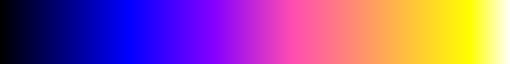

In [155]:
plt.cm.gnuplot2